### Notebook contents

- [Overview](#Overview)
- [Imports](#Imports)
- [Data](#Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Sentiment Analysis](#Sentiment-Analysis)
- [Item-based Recommender](#Collaborative-Filtering-Recommender-(Item---Based))
- [Model Evaluation](#Evaluation)

### Overview

For part of my coursework during my time in General Assembly’s Data Science Immersive program, I was tasked to design and develop a recommender system. First, I conducted a thorough analysis of the data, then a sentiment analysis on a popular restaurant in the city of Pittsburg then created a text classification model that is able to predict the rating a customer would give a restaurant they tried, based on the language (NLP) that they used in the rating. The choice to create a restaurant recommender inspired by my love to try new things (food) and to explore my curiosity about a company whose product/service I use regularly (Yelp).

### Imports

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import sparse
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import string
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

### Data

In [27]:
#df = pd.read_csv('./yelp_dataset/Pittsburgh_restaurant_reviews.csv', index_col=0)
df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date
349,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",2cFhjAZmAeOex5uHhqw_jw,5.0,"Marathon Diner may not look fancy, but I had t...",2017-10-02 05:16:37
350,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",duaUAAQXeNO9Xwz6u-_exQ,2.0,What a ripoff. For a $13 salad all you get is ...,2017-12-30 18:44:23


In [28]:
#original indexis start with 1036, let's reset the index to make this make more sense
df = df.reset_index(drop=True)
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date
0,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",2cFhjAZmAeOex5uHhqw_jw,5.0,"Marathon Diner may not look fancy, but I had t...",2017-10-02 05:16:37
1,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",duaUAAQXeNO9Xwz6u-_exQ,2.0,What a ripoff. For a $13 salad all you get is ...,2017-12-30 18:44:23
2,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",YRsBmZhGPBOLUpy04hBGdA,5.0,This experience was a joy. The food was great....,2017-08-30 09:56:43
3,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",PhhE1oerZxThQWoRBSm8VA,1.0,The one at the airport is just ... bad the ser...,2018-06-11 20:25:52
4,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",VYs7jIdZkkVIsnGt-kKM6w,5.0,Had an early flight and wife and I were hungr...,2017-09-24 10:34:47


### Exploratory Data Analysis

In [29]:
#how many rows? (138950 rows, 15 columns)
df.shape

(138950, 15)

In [30]:
#checking the data types. Every thing looks to be in the correct type
df.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code     float64
latitude        float64
longitude       float64
stars           float64
attributes       object
categories       object
user_id          object
review_stars    float64
text             object
date             object
dtype: object

In [31]:
#checking for nulls, there are none
df['city'].isnull().sum()

0

In [32]:
#user with the most reviews (433 reviews)
df['user_id'].value_counts().sort_values(ascending=False).head()

rCWrxuRC8_pfagpchtHp6A    433
Lfv4hefW1VbvaC2gatTFWA    378
4wp4XI9AxKNqJima-xahlg    339
6Ki3bAL0wx9ymbdJqbSWMA    317
d0D7L-vfQDIADolnPAcb9A    259
Name: user_id, dtype: int64

In [33]:
df['date'].nunique()

138819

In [34]:
#range of dates is from 2005 - 2018
pd.to_datetime(df.date).sort_values(ascending=False)

125874   2018-11-14 17:50:16
119082   2018-11-14 17:48:22
134918   2018-11-14 17:40:52
32642    2018-11-14 17:24:28
91776    2018-11-14 17:24:04
                 ...        
31284    2005-05-15 00:28:58
17255    2005-05-15 00:20:50
4461     2005-05-15 00:18:18
50924    2005-05-15 00:16:42
138248   2005-05-04 00:56:46
Name: date, Length: 138950, dtype: datetime64[ns]

In [35]:
df_1 = df[['user_id','text', 'date']]
df_1[df_1.loc[: ,'user_id'] == 'rCWrxuRC8_pfagpchtHp6A'].head()

,user_id,text,date
962,rCWrxuRC8_pfagpchtHp6A,"So this kid, Brian K, wanted to meet up with m...",2014-06-01 03:21:15
1180,rCWrxuRC8_pfagpchtHp6A,An old and very good friend of mine was dying ...,2015-02-23 03:49:24
1615,rCWrxuRC8_pfagpchtHp6A,Jr's has very recently been rechristened as Eg...,2012-10-22 03:08:39
2354,rCWrxuRC8_pfagpchtHp6A,CASH ONLY!\n\nIn the Potomac Avenue Pizza Wars...,2012-01-11 15:17:01
2408,rCWrxuRC8_pfagpchtHp6A,"Y'know, for a chain, Vocelli puts forth a perf...",2015-01-18 21:57:13


In [36]:
#text sample from the most frequent reviewer 
df_1.loc[1180,'text']

'An old and very good friend of mine was dying to hit Sienna Mercato prior to a show, and despite my middling prior experience with them, I caved. \n\nI\'ve found that if you don\'t get too risky in terms of your choices, you might have an above average meal here. For instance, I stuck with a Classic Beef Meatball Panino and found that it paid dividends when it came to succulence and decadently plush texture, the halves of bread tasting like the most divine buttered toast in the region. My chosen cheese was smoked gouda, which possessed an alchemist fantasy flavor blend of charred, creamy, and nutty. The Pork Bolognese sauce I requested could have been served in a cheddar-crusted crock topped with diced onion and called chili. I wouldn\'t have been able to tell the difference, and I would have been very happy with it,  the rich, meaty, bowl of stewed vine fruit providing for me a bit of a warm, comforting relief on a bitter winter\'s evening. \n\nThe House Cut French Fries were adeptly

In [37]:
# anothere text sample from the most frequent reviewer 
df_1.loc[1615,'text']

"Jr's has very recently been rechristened as Egghead's Saloon complete with a swanky new neon sign. Let's hope this guy doesn't show up to make trouble...\n\nhttp://www.marvunapp.com/Appendix4/eggheadstarr.htm\n\nBefore becoming Jr's somewhere in the low 90's, this bar was known for many, many years as Denmark's."

In [38]:
#top restaurant categories
df['categories'].value_counts().sort_values(ascending=False).head(10)

Meat Shops, Food, Specialty Food, Steakhouses, American (New), Restaurants, Gastropubs                            1816
Restaurants, American (New)                                                                                       1776
Thai, Restaurants                                                                                                 1658
Argentine, Latin American, Restaurants, Seafood                                                                   1657
Restaurants, Pizza                                                                                                1507
Pizza, Restaurants                                                                                                1295
Sandwiches, Restaurants, Botanical Gardens, Sports Bars, Bars, Arts & Entertainment, Nightlife, American (New)    1243
Restaurants, American (New), Mexican                                                                              1156
Thai, Restaurants, Noodles, Food                

In [39]:
df['categories'].nunique()

1304

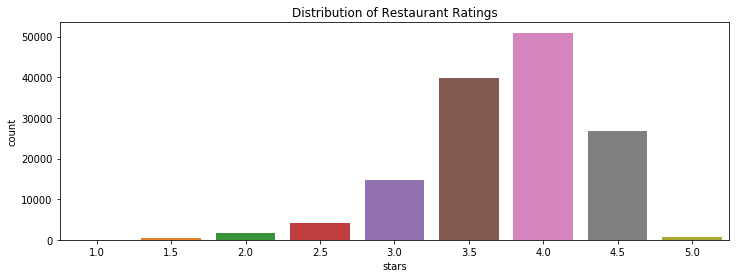

In [40]:
#distribution of restaurant ratings
plt.figure(figsize=(12,4))
ax = sns.countplot(df['stars'])
plt.title('Distribution of Restaurant Ratings');

In [41]:
#average rating of restaurants in this dataset (specifically for Philadelphia)
df['stars'].mean()

3.7789564591579703

In [42]:
#amount of unique restaurant names
len(df['name'].value_counts())

1378

In [43]:
#top 20 restaurants (with the most user ratings per restaurants)
df['name'].value_counts().sort_values(ascending=False).head(20)

Primanti Bros                      2761
Meat & Potatoes                    1816
Gaucho Parrilla Argentina          1657
Burgatory                          1415
täkō                               1156
Noodlehead                         1128
Nicky's Thai Kitchen               1118
P&G's Pamela's Diner               1068
Church Brew Works                  1041
Butcher and the Rye                 823
Sienna Mercato                      771
Fat Heads Saloon                    737
Industry Public House               735
Hofbrauhaus Pittsburgh              696
Winghart's Burger & Whiskey Bar     687
Bakersfield                         670
Eleven                              670
Kaya                                657
BRGR                                616
The Porch at Schenley               610
Name: name, dtype: int64

#### Most rated restaurant in Pittsburg
Background - Primanti Brothers (/prɪˈmænti/, locally /pər-/) is a chain of sandwich shops in the eastern United States. Founded in 1933, the chain is known for its signature sandwiches of grilled meat, melted cheese, an oil & vinegar-based coleslaw, tomato slices, and French fries between two thick slices of Italian bread. Source: https://en.wikipedia.org/wiki/Primanti_Brothers#cite_note-1

In [44]:
#let's take a closer look at the most rated restaurant in Pittsburg. It has 2761 reviews
primanti = df[df.name=='Primanti Bros']
primanti.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date
1940,09pf_DnQV5Y5y2reoIPXlw,Primanti Bros,5491 Penn Ave,Pittsburgh,PA,15206.0,40.464308,-79.932618,3.5,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Restaurants, American (New), Bars, Sports Bars...",iJMDvVg6Mgl43is4XxIKsA,2.0,Overrated is the first word that comes to mind...,2018-09-14 12:59:13
1941,09pf_DnQV5Y5y2reoIPXlw,Primanti Bros,5491 Penn Ave,Pittsburgh,PA,15206.0,40.464308,-79.932618,3.5,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Restaurants, American (New), Bars, Sports Bars...",PmXLzbOSGbpjAAyOCDteWA,4.0,Looking for a local staple that also serves up...,2017-10-25 00:29:40
1942,09pf_DnQV5Y5y2reoIPXlw,Primanti Bros,5491 Penn Ave,Pittsburgh,PA,15206.0,40.464308,-79.932618,3.5,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Restaurants, American (New), Bars, Sports Bars...",OFlH5NDvsSneAFqimufMeg,4.0,This was my first Primanti's experience and it...,2017-05-13 19:25:48
1943,09pf_DnQV5Y5y2reoIPXlw,Primanti Bros,5491 Penn Ave,Pittsburgh,PA,15206.0,40.464308,-79.932618,3.5,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Restaurants, American (New), Bars, Sports Bars...",Chm89d6MUzDl6j0SDicgXg,5.0,Great new location! Neighborhood bar feel and ...,2017-03-28 13:04:52
1944,09pf_DnQV5Y5y2reoIPXlw,Primanti Bros,5491 Penn Ave,Pittsburgh,PA,15206.0,40.464308,-79.932618,3.5,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Restaurants, American (New), Bars, Sports Bars...",mkIt8BaYxqGGhaVHt6BxQA,5.0,I've ordered here twice so far. Once for picku...,2017-09-22 20:31:09


In [45]:
#rows in the dataframe are the amount of reviews
primanti.shape

(2761, 15)

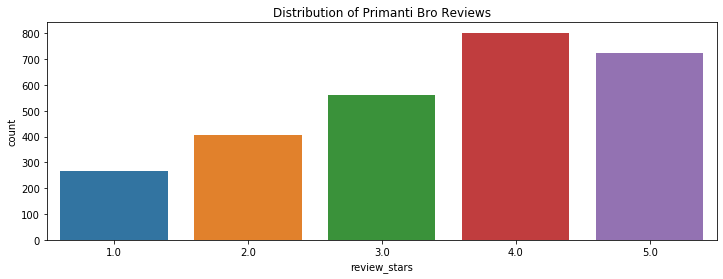

In [46]:
#distribution of restaurant ratings
plt.figure(figsize=(12,4))
ax = sns.countplot(primanti['review_stars'])
plt.title('Distribution of Primanti Bro Reviews');

In [47]:
#getting details about Primanti Bros Pittsburge location (using the index for the first review '1940')
df.loc[1940,:]

business_id                                09pf_DnQV5Y5y2reoIPXlw
name                                                Primanti Bros
address                                             5491 Penn Ave
city                                                   Pittsburgh
state                                                          PA
postal_code                                                 15206
latitude                                                  40.4643
longitude                                                -79.9326
stars                                                         3.5
attributes      {'GoodForMeal': "{'dessert': False, 'latenight...
categories      Restaurants, American (New), Bars, Sports Bars...
user_id                                    iJMDvVg6Mgl43is4XxIKsA
review_stars                                                    2
text            Overrated is the first word that comes to mind...
date                                          2018-09-14 12:59:13
Name: 1940

### Sentiment Analysis
#### When people review restaurants, they are likely to use certain language to describe their experince. Let's see if the following words are present in the reviews and if we can say what people think about this restaurant.

In [48]:
#Sentiment analysis is an area of natural language processing in which we seek to classify text as having positive or negative emotion.
#Let's build a simple function that can classify text as either having positive or negative sentiment.

words = ['yum','delicious','awesome', 'great', 'good','fantastic', 'amazing', 'love', 'horrible', 'bad', 'terrible', 'awful', 'wow', 'hate', 'gross', 'disgusting', 'yuck', 'garbage']

In [49]:
vectorizer = CountVectorizer(vocabulary=words, lowercase=False)
selected_word_count = vectorizer.fit_transform(df['text'].values.astype('U'))
vectorizer.get_feature_names()

['yum',
 'delicious',
 'awesome',
 'great',
 'good',
 'fantastic',
 'amazing',
 'love',
 'horrible',
 'bad',
 'terrible',
 'awful',
 'wow',
 'hate',
 'gross',
 'disgusting',
 'yuck',
 'garbage']

In [50]:
#how many times are our words present in the primanti corpus
primanti_bros = df[df.business_id==df.loc[1940,:].business_id]
primanti_bros_word_count = \
vectorizer.fit_transform(primanti_bros['text'].values.astype('U'))
word_count = primanti_bros_word_count.toarray()
words = pd.DataFrame(index=vectorizer.get_feature_names(), \
data=word_count.sum(axis=0)).rename(columns={0: 'Count'})
words

,Count
yum,0
delicious,2
awesome,0
great,14
good,25
fantastic,2
amazing,6
love,1
horrible,0
bad,5


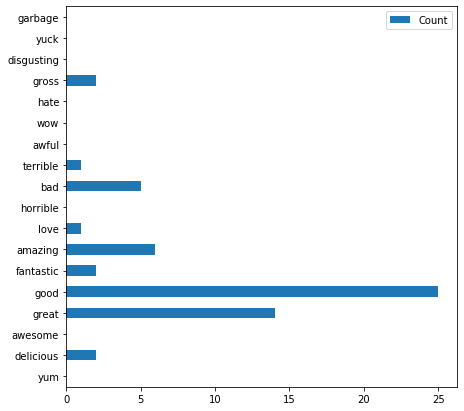

In [51]:
#plot the word list
words.plot(kind='barh', stacked=False, figsize=[7,7])

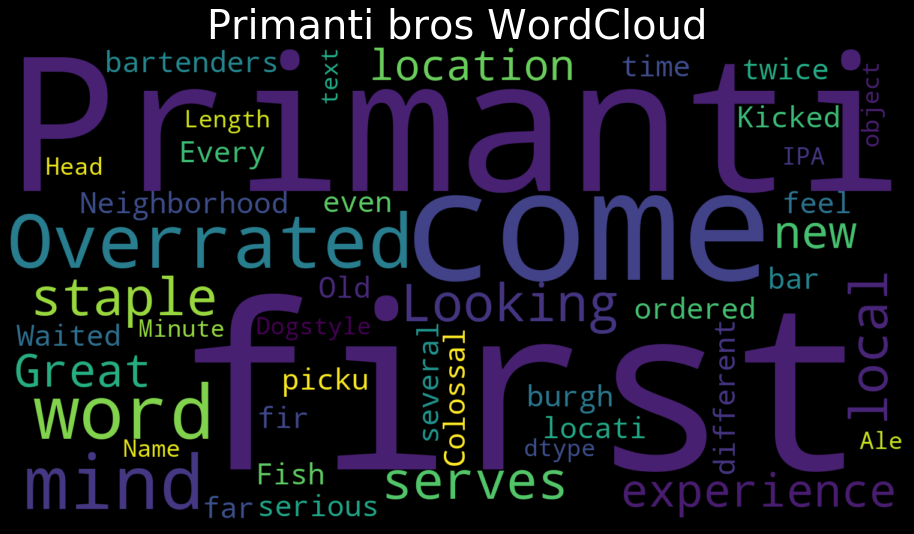

In [52]:
# Wordcloud that shows the top words used in Primanti Bros review text
wc = WordCloud(width=1500, height=800, random_state=42, max_words=200_000_000)

# generate word cloud using df['text']
wc.generate(str(primanti['text']))

# declare our figure 
plt.figure(figsize=(20,10), facecolor='k')

# add title to the graph
plt.title("Primanti bros WordCloud", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)

# after congiguration,  plot the graph
plt.show()

In [53]:
#creating a new columns that shows the amount of words in the text review
primanti['length'] = primanti['text'].apply(len)
primanti.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date,length
1940,09pf_DnQV5Y5y2reoIPXlw,Primanti Bros,5491 Penn Ave,Pittsburgh,PA,15206.0,40.464308,-79.932618,3.5,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Restaurants, American (New), Bars, Sports Bars...",iJMDvVg6Mgl43is4XxIKsA,2.0,Overrated is the first word that comes to mind...,2018-09-14 12:59:13,566
1941,09pf_DnQV5Y5y2reoIPXlw,Primanti Bros,5491 Penn Ave,Pittsburgh,PA,15206.0,40.464308,-79.932618,3.5,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Restaurants, American (New), Bars, Sports Bars...",PmXLzbOSGbpjAAyOCDteWA,4.0,Looking for a local staple that also serves up...,2017-10-25 00:29:40,776
1942,09pf_DnQV5Y5y2reoIPXlw,Primanti Bros,5491 Penn Ave,Pittsburgh,PA,15206.0,40.464308,-79.932618,3.5,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Restaurants, American (New), Bars, Sports Bars...",OFlH5NDvsSneAFqimufMeg,4.0,This was my first Primanti's experience and it...,2017-05-13 19:25:48,402
1943,09pf_DnQV5Y5y2reoIPXlw,Primanti Bros,5491 Penn Ave,Pittsburgh,PA,15206.0,40.464308,-79.932618,3.5,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Restaurants, American (New), Bars, Sports Bars...",Chm89d6MUzDl6j0SDicgXg,5.0,Great new location! Neighborhood bar feel and ...,2017-03-28 13:04:52,291
1944,09pf_DnQV5Y5y2reoIPXlw,Primanti Bros,5491 Penn Ave,Pittsburgh,PA,15206.0,40.464308,-79.932618,3.5,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Restaurants, American (New), Bars, Sports Bars...",mkIt8BaYxqGGhaVHt6BxQA,5.0,I've ordered here twice so far. Once for picku...,2017-09-22 20:31:09,581


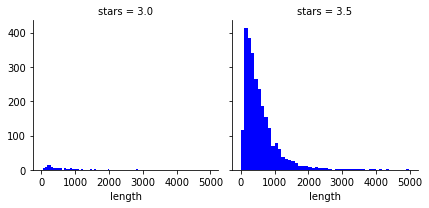

In [54]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=primanti,col='stars')
graph.map(plt.hist,'length',bins=50,color='blue')

### Modeling 

In [55]:
df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date
0,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",2cFhjAZmAeOex5uHhqw_jw,5.0,"Marathon Diner may not look fancy, but I had t...",2017-10-02 05:16:37
1,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",duaUAAQXeNO9Xwz6u-_exQ,2.0,What a ripoff. For a $13 salad all you get is ...,2017-12-30 18:44:23


In [56]:
df_1 = df[['text', 'review_stars']]
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date
0,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",2cFhjAZmAeOex5uHhqw_jw,5.0,"Marathon Diner may not look fancy, but I had t...",2017-10-02 05:16:37
1,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",duaUAAQXeNO9Xwz6u-_exQ,2.0,What a ripoff. For a $13 salad all you get is ...,2017-12-30 18:44:23
2,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",YRsBmZhGPBOLUpy04hBGdA,5.0,This experience was a joy. The food was great....,2017-08-30 09:56:43
3,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",PhhE1oerZxThQWoRBSm8VA,1.0,The one at the airport is just ... bad the ser...,2018-06-11 20:25:52
4,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",VYs7jIdZkkVIsnGt-kKM6w,5.0,Had an early flight and wife and I were hungr...,2017-09-24 10:34:47


In [57]:
#converting all text to lowercase
df_1['text'] = df_1['text'].str.lower()
#tokenize the sentences
df_1['text'] = df_1.text.str.strip().str.split('[\W_]+')

In [58]:
#removing stop words
stop = stopwords.words('english')
df_1['text'].apply(lambda x: [item for item in x if item not in stop])

0         [marathon, diner, may, look, fancy, best, airp...
1         [ripoff, 13, salad, get, iceberg, lettuce, mea...
2         [experience, joy, food, great, service, great,...
3         [one, airport, bad, servers, bored, attitude, ...
4         [early, flight, wife, hungry, noticed, maratho...
                                ...                        
138945    [clean, establishment, close, work, ample, par...
138946    [missing, chili, back, massachusetts, used, li...
138947    [usually, service, chili, decent, today, split...
138948    [fan, chain, restaurants, chilli, years, went,...
138949    [service, okay, server, didnt, ask, refills, i...
Name: text, Length: 138950, dtype: object

In [59]:
#changing the documents from individual strings to one string per document
def rejoin_words(row):
    my_list = row['text']
    joined_words = ( " ".join(my_list))
    return joined_words

df_1['text'] = df_1.apply(rejoin_words, axis=1)
df_1['text']

0         marathon diner may not look fancy but i had th...
1         what a ripoff for a 13 salad all you get is ic...
2         this experience was a joy the food was great s...
3         the one at the airport is just bad the servers...
4         had an early flight and wife and i were hungry...
                                ...                        
138945    clean establishment close to work ample parkin...
138946    i was missing the chili s back in massachusett...
138947    usually the service at chili s is decent but t...
138948    i m not a fan of chain restaurants and i ve no...
138949    service was okay but server didnt ask about re...
Name: text, Length: 138950, dtype: object

In [60]:
#should be ints, not floats 
df_1.dtypes

text             object
review_stars    float64
dtype: object

In [61]:
#look like our review stars (labels) are floats and need to be integers
df_1.review_stars.value_counts(normalize=True)

5.0    0.385808
4.0    0.287326
3.0    0.141626
1.0    0.096200
2.0    0.089039
Name: review_stars, dtype: float64

In [62]:
#since are classes are pretty unbalanced we are going to update our labels to be as such
# 1 (poor rating) (1,2 star)- 
# 2 (average or good rating (3,4 star)) 
# 3 (Excellent rating) (5 star) - 
df_1['review_stars'] = df_1['review_stars'].map( {1.0: 1, 2.0:1, 3.0:2, 4.0:2, 5.0:3})
df_1['review_stars'].sample()

81576    2
Name: review_stars, dtype: int64

In [63]:
#look like our review stars (labels) are floats and need to be integers
df_1.review_stars.value_counts(normalize=True)

2    0.428953
3    0.385808
1    0.185239
Name: review_stars, dtype: float64

In [64]:
df_1.dtypes

text            object
review_stars     int64
dtype: object

In [65]:
df_1.head()

,text,review_stars
0,marathon diner may not look fancy but i had th...,3
1,what a ripoff for a 13 salad all you get is ic...,1
2,this experience was a joy the food was great s...,3
3,the one at the airport is just bad the servers...,1
4,had an early flight and wife and i were hungry...,3


In [66]:
#lets set up our data for modeling
X = df_1['text']
y = df_1['review_stars']
print(X.head())
print(y.head())

0    marathon diner may not look fancy but i had th...
1    what a ripoff for a 13 salad all you get is ic...
2    this experience was a joy the food was great s...
3    the one at the airport is just bad the servers...
4    had an early flight and wife and i were hungry...
Name: text, dtype: object
0    3
1    1
2    3
3    1
4    3
Name: review_stars, dtype: int64


In [67]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=42)

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
#instantiating pipeline
pipe = Pipeline([('cvec', CountVectorizer()),('logreg', LogisticRegression(solver='liblinear'))])
pipe_params = {
    'cvec__max_features': [2000],
    'cvec__min_df': [10],
    'cvec__max_df': [.15, .90],
    'cvec__ngram_range': [(1,1), (1,2),]}
gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.
gs.fit(X_train, y_train)
print("best score: ",gs.best_score_)
gs.best_params_
# Save best model as gs_model.
gs_model = gs.best_estimator_
gs_model
# Score model on training set.
print("training score:", gs_model.score(X_train, y_train))
# Score model on testing set.
print("test score:", gs_model.score(X_test, y_test))

best score:  0.7335732277797768
training score: 0.7532835552356963
test score: 0.7410939186757827


### Collaborative Filtering Recommender (Item - Based)



In [69]:
df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date
0,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",2cFhjAZmAeOex5uHhqw_jw,5.0,"Marathon Diner may not look fancy, but I had t...",2017-10-02 05:16:37
1,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231.0,40.496177,-80.246011,4.0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",duaUAAQXeNO9Xwz6u-_exQ,2.0,What a ripoff. For a $13 salad all you get is ...,2017-12-30 18:44:23


In [70]:
df = df[["user_id","business_id", "stars", "date", "name"]]
df.head()

,user_id,business_id,stars,date,name
0,2cFhjAZmAeOex5uHhqw_jw,1RHY4K3BD22FK7Cfftn8Mg,4.0,2017-10-02 05:16:37,Marathon Diner
1,duaUAAQXeNO9Xwz6u-_exQ,1RHY4K3BD22FK7Cfftn8Mg,4.0,2017-12-30 18:44:23,Marathon Diner
2,YRsBmZhGPBOLUpy04hBGdA,1RHY4K3BD22FK7Cfftn8Mg,4.0,2017-08-30 09:56:43,Marathon Diner
3,PhhE1oerZxThQWoRBSm8VA,1RHY4K3BD22FK7Cfftn8Mg,4.0,2018-06-11 20:25:52,Marathon Diner
4,VYs7jIdZkkVIsnGt-kKM6w,1RHY4K3BD22FK7Cfftn8Mg,4.0,2017-09-24 10:34:47,Marathon Diner


In [71]:
#some EDA
df.groupby('name')['stars'].mean().sort_values(ascending=False).head()

name
Crazy Mocha                                  5.0
Wise County Biscuits                         5.0
Musa Caribbean / Cajun Fare                  5.0
Siempre Algo                                 5.0
Rudy Martino Original House of Submarines    5.0
Name: stars, dtype: float64

In [72]:
#reminding ourselves of the most rated restaurants
df.groupby('name')['stars'].count().sort_values(ascending=False).head()

name
Primanti Bros                2761
Meat & Potatoes              1816
Gaucho Parrilla Argentina    1657
Burgatory                    1415
täkō                         1156
Name: stars, dtype: int64

In [73]:
ratings = pd.DataFrame(df.groupby('name')['stars'])
ratings.head()

,0,1
0,5 Fools,94263 3.5 94264 3.5 94265 3.5 94266 ...
1,51 Wings and Things,54471 4.0 54472 4.0 54473 4.0 54474 ...
2,52nd Street Market,69543 5.0 69544 5.0 69545 5.0 69546 ...
3,5801 Video Lounge and Café,59035 4.0 59036 4.0 59037 4.0 59038 ...
4,61C Cafe,80481 3.5 80482 3.5 80483 3.5 80484 ...


In [74]:
ratings['num_of_ratings'] = pd.DataFrame(df.groupby('name')['stars'].count())
ratings.head()

,0,1,num_of_ratings
0,5 Fools,94263 3.5 94264 3.5 94265 3.5 94266 ...,NaN
1,51 Wings and Things,54471 4.0 54472 4.0 54473 4.0 54474 ...,NaN
2,52nd Street Market,69543 5.0 69544 5.0 69545 5.0 69546 ...,NaN
3,5801 Video Lounge and Café,59035 4.0 59036 4.0 59037 4.0 59038 ...,NaN
4,61C Cafe,80481 3.5 80482 3.5 80483 3.5 80484 ...,NaN


In [75]:
#creating a matrix that has the user ids on one access and the restaurant names on another axis. 
# Each cell will then consist of the rating the user gave to that restaurant. 
#NaN values are because most people have not rated (or tried) most restaurants.
pivot = pd.pivot_table(df, index='name', columns='user_id', values='stars')
pivot.head()

user_id,--CH8yRGXhO2MmbF-4BWXg,--EMqnd727rtC0G5Oc-Mrg,--Hc1I83HDuQWI6VBeSAEA,--OECAoqfSTBaZ3biOyzwA,--RBfYfIpx44V5Kux2fPFA,--TvGNywm2I1iwNWZmerBA,--UizzbnQlZg7bEv2oXEyg,--Yrq6JLmQNdbZkWJsHy5Q,--bQQheos4R1RI4wPK6UUg,--cO5bedOWodnt8UgamQNA,...,zzDN7KhMfU5UPbTUSfYSyQ,zzFZXZ-jiW_AhHR_w25aeA,zzG4AzS2GdW0KJxCwbvV1g,zzGUiwY-emOE0dkTRV0ztw,zzSujOEhYzdCduvpLisCvw,zzTHRzFR-a_F0YZ7c56vcA,zzYMFAyY5-ZpsPaknmt8tw,zzanZzhoA3wufshSrE5Q-g,zzbCMW84h24boAefr_y6Aw,zzx7k7JqCQNhhqL4VJxL0A
name,,,,,,,,,,,,,,,,,,,,,
5 Fools,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51 Wings and Things,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52nd Street Market,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5801 Video Lounge and Café,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61C Cafe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
pivot.shape

(1378, 48813)

In [77]:
ratings.sort_values('num_of_ratings',ascending=False).head(10)

,0,1,num_of_ratings
0,5 Fools,94263 3.5 94264 3.5 94265 3.5 94266 ...,NaN
1,51 Wings and Things,54471 4.0 54472 4.0 54473 4.0 54474 ...,NaN
2,52nd Street Market,69543 5.0 69544 5.0 69545 5.0 69546 ...,NaN
3,5801 Video Lounge and Café,59035 4.0 59036 4.0 59037 4.0 59038 ...,NaN
4,61C Cafe,80481 3.5 80482 3.5 80483 3.5 80484 ...,NaN
5,7 Senses,36597 4.5 36598 4.5 36599 4.5 Name: s...,NaN
6,ACE Hotel Pittsburgh,29848 4.0 29849 4.0 29850 4.0 29851 ...,NaN
7,Acorn Pittsburgh,88576 4.5 88577 4.5 88578 4.5 88579 ...,NaN
8,Adda Coffee & Tea House,81500 4.5 81501 4.5 81502 4.5 81503 ...,NaN
9,Adrian's Pizza,8125 3.5 8126 3.5 8127 3.5 8128 ...,NaN


In [78]:
ratings.head()

,0,1,num_of_ratings
0,5 Fools,94263 3.5 94264 3.5 94265 3.5 94266 ...,NaN
1,51 Wings and Things,54471 4.0 54472 4.0 54473 4.0 54474 ...,NaN
2,52nd Street Market,69543 5.0 69544 5.0 69545 5.0 69546 ...,NaN
3,5801 Video Lounge and Café,59035 4.0 59036 4.0 59037 4.0 59038 ...,NaN
4,61C Cafe,80481 3.5 80482 3.5 80483 3.5 80484 ...,NaN


In [79]:
sparse_pivot = sparse.csr_matrix(pivot.fillna(0))

In [80]:
#calculate cosine similarity using sklearns built-in pairwise_distances function
recommender = cosine_similarity(sparse_pivot)
recommender_df = pd.DataFrame(recommender, columns=pivot.index, index=pivot.index)
recommender_df.head()

name,5 Fools,51 Wings and Things,52nd Street Market,5801 Video Lounge and Café,61C Cafe,7 Senses,ACE Hotel Pittsburgh,Acorn Pittsburgh,Adda Coffee & Tea House,Adrian's Pizza,...,Zombie Den: Bar Of The Dead,Zone 28,Zorba's Gyros,Zoup!,Zuppas Delicatessen,honeygrow,iNoodle,io Deli,the pizza company,täkō
name,,,,,,,,,,,,,,,,,,,,,
5 Fools,1.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
51 Wings and Things,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.016784,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.089443,0.0,0.025209
52nd Street Market,0.0,0.0,1.0,0.000000,0.000000,0.0,0.027116,0.000000,0.025286,0.0000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.014411
5801 Video Lounge and Café,0.0,0.0,0.0,1.000000,0.035494,0.0,0.012825,0.000000,0.000000,0.0228,...,0.057354,0.016222,0.038778,0.0,0.030657,0.000000,0.0,0.000000,0.0,0.013631
61C Cafe,0.0,0.0,0.0,0.035494,1.000000,0.0,0.011532,0.000000,0.043013,0.0000,...,0.051571,0.000000,0.000000,0.0,0.000000,0.010314,0.0,0.000000,0.0,0.021450


### Evaluation

In [81]:
search = 'Primanti Bros'

for title in df.loc[df['name'].str.contains(search), 'name']:
    print(title)
    print('Average rating', pivot.loc[title, :].mean())
    print('Number of ratings', pivot.T[title].count())
    print('10 closest restaurants')
    print(recommender_df[title].sort_values()[1:11])
    print('*******************************************************************************************')

Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                           

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery            

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Gro

Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Gro

Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery            

Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery            

Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery            

Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe    

Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Gro

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe    

Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe    

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery            

Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery            

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe    

Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe    

Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe    

Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe    

Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe    

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe    

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe    

Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe    

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe    

Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Gro

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market                                    0.0
Happiness Is Homemade                            0.0
Holy Trinity "Taste of Greece" Greek Festival    0.0
Homerun  Harry's Sports Bar & Grille             0.0
Hong Kong Express II                             0.0
Houlihan's                                       0.0
Name: Primanti Bros, dtype: float64
*******************************************************************************************
Primanti Bros
Average rating 3.48291729702471
Number of ratings 2644
10 closest restaurants
name
Garden View Cafe                                 0.0
Grecian Isles                                    0.0
Green Front Inn                                  0.0
Grounded Cafe & Beanery                          0.0
Hanini Market               

In [84]:
search = 'Noodlehead'

for title in df.loc[df['name'].str.contains(search), 'name']:
    print(title)
    print('Average rating', pivot.loc[title, :].mean())
    print('Number of ratings', pivot.T[title].count())
    print('10 closest restaurants')
    print(recommender_df[title].sort_values()[1:11])
    print('*******************************************************************************************')

Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro P

Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                          

Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Linco

Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Linco

Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Linco

name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0

Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza       

name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0

Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Linco

Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Linco

Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza       

name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0

name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0

Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Linco

name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0

Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                           0.0
Kings                                   0.0
Preeti's PiTT                           0.0
La Felice                               0.0
Name: Noodlehead, dtype: float64
*******************************************************************************************
Noodlehead
Average rating 4.5
Number of ratings 1096
10 closest restaurants
name
Rice King                               0.0
Ribs N Bread                            0.0
King's Hometown Grille                  0.0
Revival on Lincoln                      0.0
Red Dragon                              0.0
Radisson Hotel Pittsburgh Green Tree    0.0
Quattro Pizza                          

In [85]:
search = '5 fools'

for title in df.loc[df['name'].str.contains(search), 'name']:
    print(title)
    print('Average rating', pivot.loc[title, :].mean())
    print('Number of ratings', pivot.T[title].count())
    print('10 closest restaurants')
    print(recommender_df[title].sort_values()[1:11])
    print('*******************************************************************************************')

### Next Steps

#### Model Refinement
Larger portion of Yelp data to improve accuracy for classification model. 
#### AWS/Google Cloud
for easier management of a larger dataset
#### Different type of recommenders
User-based collaborative filtering, hybrid, Content-based
#### Locate the popular method for Validation post recommendation
#### Mobile App that recommends restaurants